# Robustness checks

To do 
- Heuristic sizes: run simulations, statistics tables, and overview results
- Consider creating heatmaps for all the results?
- Add a description of the notebook at the start

## Setup

In [1]:
import os
import pprint
from math import comb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from data_analysis.statistics import produce_df_1samp
from figures_scripts.heatmap import visualize_heatmap
from grid_simulation import GridSimulation
from models.generate_teams import generate_diverse_team, generate_expert_team
from models.sources import Sources

## Heuristic sizes

Done
- Consider heuristic size 7 and 9, i.e., homogeneous heuristic sizes.
- Consider a pool of agents with heterogeneous heuristic sizes in `[5, 7, 9]`.

As a reminder, the original settings were:

In [28]:
n_sources_list = [13, 17]
heuristic_size = 5

for n_sources in n_sources_list:
    n_possible_heuristics = comb(n_sources, heuristic_size)
    print(f"{n_sources=}, {heuristic_size=}, {n_possible_heuristics=:,}")

n_sources=13, heuristic_size=5, n_possible_heuristics=1,287
n_sources=17, heuristic_size=5, n_possible_heuristics=6,188


### Homogeneous case

#### Simulations

We are varying `n_sources_list` and `heuristic_size`

In [31]:
n_sources_list = [13, 15]
heuristic_size = 7

for n_sources in n_sources_list:
    n_possible_heuristics = comb(n_sources, heuristic_size)
    print(f"{n_sources=}, {heuristic_size=}, {n_possible_heuristics=:,}")

n_sources=13, heuristic_size=7, n_possible_heuristics=1,716
n_sources=15, heuristic_size=7, n_possible_heuristics=6,435


In [ ]:
rels = [
    ("equi", rel_mean, 0.2)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 15],
    reliability_distribution_list=rels,
    heuristic_size=7,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

In [32]:
n_sources_list = [15]
heuristic_size = 9

for n_sources in n_sources_list:
    n_possible_heuristics = comb(n_sources, heuristic_size)
    print(f"{n_sources=}, {heuristic_size=}, {n_possible_heuristics=:,}")

n_sources=15, heuristic_size=9, n_possible_heuristics=5,005


In [ ]:
rels = [
    ("equi", rel_mean, 0.2)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[15],
    reliability_distribution_list=rels,
    heuristic_size=9,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

#### Simulation statistics tables

#### Simulation overview results

New method for generating heatmap with multiple heuristics

In [ ]:
def visualize_heatmap_multiple_heuristics(
    outcome: str = "accuracy",
    heuristic_size_list: list = [5, 7, 9],
    measure: str = "absolute",
    mask: bool = True,
    colors: bool = False,
    show: bool = True,
):

    df_total = pd.DataFrame()

    for heuristic_size in heuristic_size_list:
        df = produce_df_1samp(outcome=outcome, heuristic_size=heuristic_size, perform_bca_ci=False)
        df["heuristic_size"] = heuristic_size
        if measure == "absolute":
            df["effect_percent"] = 100 * df["difference"]
        if measure == "relative":
            df["effect_percent"] = df["error_reduction"]
        
        df_total = pd.concat([df_total, df])

    pivot_df = df_total.pivot(
        index="rel_mean",
        columns=["heuristic_size", "n_sources"],
        values="effect_percent",
    )
    pivot_df.sort_index(inplace=True, ascending=False)

    sns.set_style("white")
    font_style = {"family": "Times New Roman", "size": 12}
    plt.rc("font", **font_style)
    plt.figure(figsize=(8, 3))

    heatmap_df = abs(pivot_df)
    heatmap_params = {
        # "annot": True,
        "cmap": "gray_r",  # "coolwarm"
        "square": True,
        "cbar_kws": {"shrink": 0.4},
    }
    if colors:
        heatmap_params["cmap"] = "coolwarm"
        heatmap_params["center"] = 0
        heatmap_df = pivot_df        

    if measure == "absolute":
        heatmap_params["vmin"] = -10
        heatmap_params["vmax"] = 10
        heatmap_params["annot"] = True
        if not colors:
            labels = pivot_df.copy()
            labels = labels.map(
                lambda x: (f"+{x:.1f}" if "-" not in str(x) else f"{x:.1f}")
            )
            heatmap_params["annot"] = labels
            heatmap_params["fmt"] = ""
            heatmap_params["vmin"] = 0

    if measure == "relative":
        heatmap_params["vmin"] = -100
        heatmap_params["vmax"] = 100
        heatmap_params["fmt"] = "g"
        heatmap_params["annot"] = True
        if not colors:
            labels = pivot_df.copy()
            labels = labels.map(
                lambda x: f"+{x:.0f}" if "-" not in str(x) else f"{x:.0f}"
            )
            heatmap_params["annot"] = labels
            heatmap_params["fmt"] = ""
            heatmap_params["vmin"] = 0

    if not mask:
        fig = sns.heatmap(heatmap_df, **heatmap_params)
    else:
        mask_df = df_total.pivot(
            index="rel_mean",
            columns=["n_sources", "heuristic_size"],
            values="p_value",
        )
        mask_df = mask_df.astype(bool)
        mask_df.sort_index(inplace=True, ascending=False)
        fig = sns.heatmap(
            heatmap_df,
            mask=mask_df,
            # annot=labels,
            **heatmap_params,
        )

    fig.set_xlabel("Heuristic size (#) - Sources (#)")
    fig.set_ylabel("Reliability (mean)")
    plt.yticks(rotation=0)
    plt.savefig(
        f"figures/heatmap_{outcome}_{measure}.eps",
        bbox_inches="tight",
        dpi=800,
        format="eps",
    )
    plt.savefig(
        f"figures/heatmap_{outcome}_{measure}.png",
        bbox_inches="tight",
        dpi=800,
    )
    if show:
        plt.show()
    plt.close()

Individual scores for different heuristic sizes

In [ ]:
data_total = np.empty((0, 3))
scores_df = pd.DataFrame()
for heuristic_size in [int(5), int(7), int(9)]:
    for rel_mean in [0.55, 0.60, 0.65, 0.70, 0.75]:
        n_sources = 13
        # heuristic_size = 5
        reliability_distribution = ("equi", (rel_mean - 0.1, rel_mean + 0.1))
        sources = Sources(n_sources, reliability_distribution)
        n_possible_heuristics = comb(n_sources, heuristic_size)
        team = generate_expert_team(sources, heuristic_size, n_possible_heuristics)
        data = np.array([[agent.score, rel_mean, heuristic_size] for agent in team.members])
        data_total = np.append(data_total, data, axis=0)
        # data_df = pd.DataFrame(data, columns=["score", "rel_mean", "heuristic_size"])
        # scores_df = pd.concat([scores_df, data_df], axis=1)
scores_df = pd.DataFrame(data_total, columns=["score", "rel_mean", "heuristic_size"])

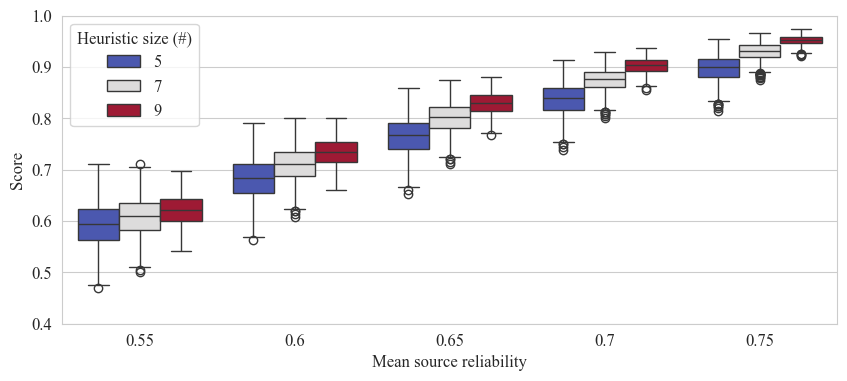

In [ ]:
sns.set_style("whitegrid")
font_style = {"family": "Times New Roman", "size": 12}
plt.rc("font", **font_style)
plt.figure(figsize=(10, 4))

fig = sns.boxplot(data=scores_df, x="rel_mean", y="score", hue="heuristic_size", palette="coolwarm")
fig.set_yticks(0.4 + 0.1 * np.arange(7, dtype=int))
# fig.set_title("Individual scores")
fig.set_xlabel("Mean source reliability")
fig.set_ylabel("Score")

fig.legend(title="Heuristic size (#)", loc="upper left")
fig.legend_.texts[0].set_text(int(5))
fig.legend_.texts[1].set_text(int(7))
fig.legend_.texts[2].set_text(int(9))
plt.savefig(
    f"figures/individual_scores_various_heuristics.png",
    bbox_inches="tight",
    dpi=800,
)


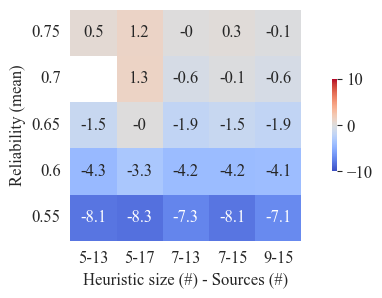

In [ ]:
visualize_heatmap_multiple_heuristics(outcome="accuracy", colors=True, show=True)

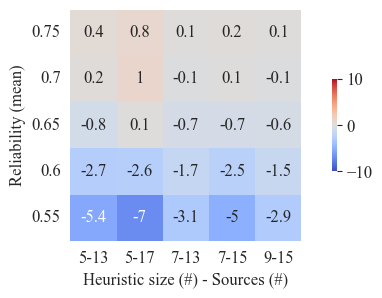

In [ ]:
visualize_heatmap_multiple_heuristics(outcome="pool_accuracy", colors=True, show=True)

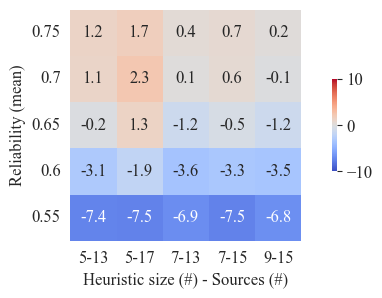

In [ ]:
visualize_heatmap_multiple_heuristics(outcome="bounded_pool_accuracy", colors=True, show=True)

### Heterogenous case

#### Simulations

We consider heterogeneous pools of agents with heuristic size in `[5, 7, 9]` and in settings with 15 sources.

In [25]:
n_sources = 15
n_possible_heuristics = comb(n_sources, 5) + comb(n_sources, 7) + comb(n_sources, 9 )
print(f"{n_possible_heuristics=:,}")

n_possible_heuristics=14,443


In [ ]:
rels = [
    ("equi", rel_mean, 0.2)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[15],
    reliability_distribution_list=rels,
    heuristic_size=[5, 7, 9],
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

#### Simulation statistics tables

#### Simulation overview results

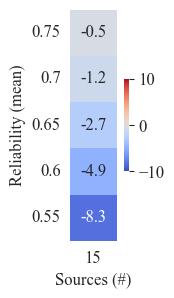

In [ ]:
visualize_heatmap(outcome="accuracy", heuristic_size=[5, 7, 9], colors=True, show=True)

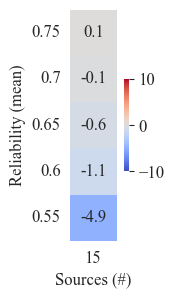

In [ ]:
visualize_heatmap(outcome="pool_accuracy", heuristic_size=[5, 7, 9], colors=True, show=True)

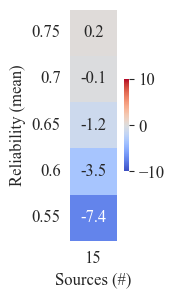

In [ ]:
visualize_heatmap(outcome="bounded_pool_accuracy", heuristic_size=[5, 7, 9], colors=True, show=True)

## Reliability distributions

Done
- Variance 0.15 and 0.25 for all mean reliabilities

### Simulations

In [ ]:
rels = [
    ("equi", rel_mean, 0.15)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 17],
    reliability_distribution_list=rels,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

,team_types,n_sources,reliability_distribution,heuristic_size,team_size,n_samples,estimate_sample_size
0,"[expert, diverse]",17,"(equi, 0.55, 0.15)",5,9,1000,None
1,"[expert, diverse]",17,"(equi, 0.6, 0.15)",5,9,1000,None
2,"[expert, diverse]",17,"(equi, 0.65, 0.15)",5,9,1000,None
3,"[expert, diverse]",17,"(equi, 0.7, 0.15)",5,9,1000,None
4,"[expert, diverse]",17,"(equi, 0.75, 0.15)",5,9,1000,None


Running simulation 0 out of 5...


Calculating/estimating accuracies and bounded pool accuracies:   0%|          | 0/1001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
rels = [
    ("equi", rel_mean, 0.25)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 17],
    reliability_distribution_list=rels,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

          team_types  n_sources reliability_distribution  heuristic_size  \
0  [expert, diverse]         13       (equi, 0.55, 0.25)               5   
1  [expert, diverse]         13        (equi, 0.6, 0.25)               5   
2  [expert, diverse]         13       (equi, 0.65, 0.25)               5   
3  [expert, diverse]         13        (equi, 0.7, 0.25)               5   
4  [expert, diverse]         13       (equi, 0.75, 0.25)               5   

   team_size  n_samples estimate_sample_size  
0          9       1000                 None  
1          9       1000                 None  
2          9       1000                 None  
3          9       1000                 None  
4          9       1000                 None  
Running simulation 0
team_types                   [expert, diverse]
n_sources                                   13
reliability_distribution    (equi, 0.55, 0.25)
heuristic_size                               5
team_size                                    9
n_sam

100%|██████████| 1001/1001 [05:22<00:00,  3.11it/s]


Running simulation 1
team_types                  [expert, diverse]
n_sources                                  13
reliability_distribution    (equi, 0.6, 0.25)
heuristic_size                              5
team_size                                   9
n_samples                                1000
estimate_sample_size                     None
Name: 1, dtype: object


100%|██████████| 1001/1001 [05:01<00:00,  3.32it/s]


Running simulation 2
team_types                   [expert, diverse]
n_sources                                   13
reliability_distribution    (equi, 0.65, 0.25)
heuristic_size                               5
team_size                                    9
n_samples                                 1000
estimate_sample_size                      None
Name: 2, dtype: object


100%|██████████| 1001/1001 [04:58<00:00,  3.35it/s]


Running simulation 3
team_types                  [expert, diverse]
n_sources                                  13
reliability_distribution    (equi, 0.7, 0.25)
heuristic_size                              5
team_size                                   9
n_samples                                1000
estimate_sample_size                     None
Name: 3, dtype: object


100%|██████████| 1001/1001 [04:54<00:00,  3.39it/s]


Running simulation 4
team_types                   [expert, diverse]
n_sources                                   13
reliability_distribution    (equi, 0.75, 0.25)
heuristic_size                               5
team_size                                    9
n_samples                                 1000
estimate_sample_size                      None
Name: 4, dtype: object


100%|██████████| 1001/1001 [04:53<00:00,  3.41it/s]


### Simulation statistics tables

In [55]:
for outcome in ["accuracy", "pool_accuracy", "bounded_pool_accuracy"]:
    print("="*80)
    print(f"{str(outcome).capitalize()}")
    print("="*80)
    for rel_range in [0.15, 0.2, 0.25]:
        df_dummy = produce_df_1samp(outcome=outcome, reliability_range=rel_range)
        print(f"Reliability range: {rel_range}")
        display(df_dummy)
        print("-"*80)
    

Accuracy
Reliability range: 0.15


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.053,-17.2,0.0,0.866,-0.053829,-0.052896,False,1.000
1,13,0.60,-0.019,-8.5,0.0,0.866,-0.019162,-0.018291,False,1.000
2,13,0.65,0.003,2.4,0.0,0.669,0.003159,0.003749,False,0.794
3,13,0.70,0.014,19.3,0.0,0.866,0.013900,0.014334,False,1.000
4,13,0.75,0.014,45.4,0.0,0.866,0.013983,0.014228,False,1.000


--------------------------------------------------------------------------------
Reliability range: 0.2


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.081,-28.6,0.0000,0.866,-0.080812,-0.080353,False,1.0000
1,13,0.60,-0.043,-21.9,0.0000,0.866,-0.043278,-0.042947,False,1.0000
2,13,0.65,-0.015,-12.1,0.0000,0.866,-0.015336,-0.015087,False,0.9998
3,13,0.70,0.000,0.1,0.1626,0.014,-0.000025,0.000170,False,0.5064
4,13,0.75,0.005,15.3,0.0000,0.863,0.004598,0.004706,False,0.9792
5,17,0.55,-0.083,-31.6,0.0000,0.866,-0.083597,-0.083114,False,1.0000
6,17,0.60,-0.033,-18.2,0.0000,0.866,-0.033286,-0.032955,False,1.0000
7,17,0.65,-0.000,-0.3,0.0000,0.087,-0.000527,-0.000246,False,0.5278
8,17,0.70,0.013,24.9,0.0000,0.866,0.012695,0.012833,False,1.0000
9,17,0.75,0.012,66.8,0.0000,0.866,0.012000,0.012066,False,1.0000


--------------------------------------------------------------------------------
Reliability range: 0.25


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.107,-42.0,0.0,0.866,-0.107793,-0.106581,False,1.000
1,13,0.60,-0.065,-37.3,0.0,0.866,-0.065533,-0.063970,False,1.000
2,13,0.65,-0.033,-30.3,0.0,0.866,-0.033243,-0.032099,False,1.000
3,13,0.70,-0.013,-21.4,0.0,0.866,-0.012919,-0.012130,False,0.999
4,13,0.75,-0.003,-11.7,0.0,0.827,-0.003212,-0.002880,False,0.901


--------------------------------------------------------------------------------
Pool_accuracy
Reliability range: 0.15


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.035,-11.0,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.012,-5.4,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,0.003,2.7,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.009,15.0,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.008,33.8,NaN,NaN,NaN,NaN,False,NaN


--------------------------------------------------------------------------------
Reliability range: 0.2


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.054,-17.7,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.027,-13.4,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,-0.008,-6.6,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.002,2.7,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.004,15.8,NaN,NaN,NaN,NaN,False,NaN
5,17,0.55,-0.070,-26.4,NaN,NaN,NaN,NaN,False,NaN
6,17,0.60,-0.026,-15.1,NaN,NaN,NaN,NaN,False,NaN
7,17,0.65,0.001,0.8,NaN,NaN,NaN,NaN,False,NaN
8,17,0.70,0.010,24.7,NaN,NaN,NaN,NaN,False,NaN
9,17,0.75,0.008,66.0,NaN,NaN,NaN,NaN,False,NaN


--------------------------------------------------------------------------------
Reliability range: 0.25


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.072,-25.3,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.041,-22.4,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,-0.018,-17.1,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,-0.005,-9.6,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,-0.000,-0.6,NaN,NaN,NaN,NaN,False,NaN


--------------------------------------------------------------------------------
Bounded_pool_accuracy
Reliability range: 0.15


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.047,-15.1,0.0,0.866,-0.047055,-0.046398,False,1.0
1,13,0.60,-0.007,-3.3,0.0,0.866,-0.007471,-0.007344,False,1.0
2,13,0.65,0.017,12.9,0.0,0.866,0.016680,0.016926,False,1.0
3,13,0.70,0.025,40.2,0.0,0.866,0.025131,0.025291,False,1.0
4,13,0.75,0.021,86.8,0.0,0.866,0.021188,0.021275,False,1.0


--------------------------------------------------------------------------------
Reliability range: 0.2


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.074,-26.4,0.0,0.866,-0.074313,-0.074275,False,1.0000
1,13,0.60,-0.031,-15.9,0.0,0.866,-0.031461,-0.031401,False,1.0000
2,13,0.65,-0.002,-1.8,0.0,0.774,-0.002296,-0.002218,False,0.8677
3,13,0.70,0.011,17.6,0.0,0.866,0.010868,0.010942,False,1.0000
4,13,0.75,0.012,48.7,0.0,0.866,0.011568,0.011606,False,1.0000
5,17,0.55,-0.075,-28.3,0.0,0.866,-0.074956,-0.074850,False,1.0000
6,17,0.60,-0.019,-10.6,0.0,0.866,-0.019429,-0.019241,False,1.0000
7,17,0.65,0.013,13.2,0.0,0.866,0.013334,0.013533,False,0.9992
8,17,0.70,0.023,54.6,0.0,0.866,0.022808,0.022920,False,1.0000
9,17,0.75,0.017,133.2,0.0,0.866,0.017394,0.017447,False,1.0000


--------------------------------------------------------------------------------
Reliability range: 0.25


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.101,-39.6,0.0,0.866,-0.100946,-0.100419,False,1.000
1,13,0.60,-0.053,-30.7,0.0,0.866,-0.053672,-0.053229,False,1.000
2,13,0.65,-0.020,-18.3,0.0,0.866,-0.019945,-0.019562,False,1.000
3,13,0.70,-0.002,-2.9,0.0,0.774,-0.001889,-0.001622,False,0.868
4,13,0.75,0.004,15.7,0.0,0.866,0.003514,0.003650,False,0.999


--------------------------------------------------------------------------------


### Simulation overview results

In [ ]:
def display_results_range(outcome: str = "accuracy", n_sources: int = 13):
    data = []
    for rel_range in [0.15, 0.2, 0.25]:
        df_dummy = produce_df_1samp(outcome=outcome, reliability_range=rel_range, perform_bca_ci=False)
        for idx, row in df_dummy.iterrows():
            n_sources = row["n_sources"]
            rel_mean = row["rel_mean"]
            difference = row["difference"]
            p_value = row["p_value"]
            data.append([n_sources, rel_mean, rel_range, difference, p_value])
    
    df_results = pd.DataFrame(
        data, 
        columns=["n_sources", "rel_mean", "rel_range", "difference", "p_value"])
    df_results.loc[~(df_results["p_value"] > 0.001), "effect_percent"] = 100 * df_results["difference"]
    df_results = df_results[df_results["n_sources"] == n_sources]
    return df_results.pivot(index="rel_mean", columns="rel_range", values="effect_percent")
    

In [ ]:
for outcome in ["accuracy", "pool_accuracy", "bounded_pool_accuracy"]:
    print("="*40)
    print(f"{str(outcome).capitalize()}")
    print("="*40)
    for n_sources in [13, 17]:
        print(f"Number of sources: {n_sources}" + "="* 30)
        display(display_results_range(outcome, n_sources))

Accuracy


rel_range,0.15,0.20,0.25
rel_mean,,,
0.55,-5.33,-8.06,-10.72
0.60,-1.88,-4.31,-6.48
0.65,0.34,-1.52,-3.26
0.70,1.41,NaN,-1.25
0.75,1.41,0.46,-0.31


Pool_accuracy


rel_range,0.15,0.20,0.25
rel_mean,,,
0.55,-3.51,-5.35,-7.15
0.60,-1.17,-2.69,-4.14
0.65,0.35,-0.79,-1.85
0.70,0.92,0.16,-0.52
0.75,0.80,0.36,-0.01


Bounded_pool_accuracy


rel_range,0.15,0.20,0.25
rel_mean,,,
0.55,-4.67,-7.43,-10.09
0.60,-0.74,-3.14,-5.34
0.65,1.68,-0.23,-1.98
0.70,2.52,1.09,-0.17
0.75,2.12,1.16,0.36


## Team size

Done:
- Consider team size 3, 5 and 7

### Simulations

In [ ]:
rels = [
    ("equi", rel_mean, 0.2)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

team_size = 3

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 17],
    reliability_distribution_list=rels,
    team_size=team_size,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

          team_types  n_sources reliability_distribution  heuristic_size  \
0  [expert, diverse]         13        (equi, 0.55, 0.2)               5   
1  [expert, diverse]         13         (equi, 0.6, 0.2)               5   
2  [expert, diverse]         13        (equi, 0.65, 0.2)               5   
3  [expert, diverse]         13         (equi, 0.7, 0.2)               5   
4  [expert, diverse]         13        (equi, 0.75, 0.2)               5   

   team_size  n_samples estimate_sample_size  
0          3       1000                 None  
1          3       1000                 None  
2          3       1000                 None  
3          3       1000                 None  
4          3       1000                 None  
Running simulation 0


100%|██████████| 1001/1001 [03:58<00:00,  4.20it/s]


Running simulation 1


100%|██████████| 1001/1001 [04:35<00:00,  3.63it/s]


Running simulation 2


100%|██████████| 1001/1001 [04:43<00:00,  3.53it/s]


Running simulation 3


100%|██████████| 1001/1001 [04:44<00:00,  3.52it/s]


Running simulation 4


100%|██████████| 1001/1001 [04:36<00:00,  3.61it/s]


In [ ]:
team_size = 5

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 17],
    reliability_distribution_list=rels,
    team_size=team_size,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

          team_types  n_sources reliability_distribution  heuristic_size  \
0  [expert, diverse]         13        (equi, 0.55, 0.2)               5   
1  [expert, diverse]         13         (equi, 0.6, 0.2)               5   
2  [expert, diverse]         13        (equi, 0.65, 0.2)               5   
3  [expert, diverse]         13         (equi, 0.7, 0.2)               5   
4  [expert, diverse]         13        (equi, 0.75, 0.2)               5   

   team_size  n_samples estimate_sample_size  
0          5       1000                 None  
1          5       1000                 None  
2          5       1000                 None  
3          5       1000                 None  
4          5       1000                 None  
Running simulation 0


100%|██████████| 1001/1001 [04:17<00:00,  3.89it/s]


Running simulation 1


100%|██████████| 1001/1001 [04:21<00:00,  3.82it/s]


Running simulation 2


100%|██████████| 1001/1001 [04:18<00:00,  3.88it/s]


Running simulation 3


100%|██████████| 1001/1001 [04:16<00:00,  3.90it/s]


Running simulation 4


100%|██████████| 1001/1001 [04:18<00:00,  3.87it/s]


In [ ]:
team_size = 7

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[13, 17],
    reliability_distribution_list=rels,
    team_size=team_size,
    n_samples=10**3,
    estimate_sample_size=10**3,
).run()

          team_types  n_sources reliability_distribution  heuristic_size  \
0  [expert, diverse]         13        (equi, 0.55, 0.2)               5   
1  [expert, diverse]         13         (equi, 0.6, 0.2)               5   
2  [expert, diverse]         13        (equi, 0.65, 0.2)               5   
3  [expert, diverse]         13         (equi, 0.7, 0.2)               5   
4  [expert, diverse]         13        (equi, 0.75, 0.2)               5   

   team_size  n_samples estimate_sample_size  
0          7       1000                 None  
1          7       1000                 None  
2          7       1000                 None  
3          7       1000                 None  
4          7       1000                 None  
Running simulation 0


100%|██████████| 1001/1001 [04:47<00:00,  3.48it/s]


Running simulation 1


100%|██████████| 1001/1001 [04:30<00:00,  3.70it/s]


Running simulation 2


100%|██████████| 1001/1001 [04:35<00:00,  3.63it/s]


Running simulation 3


100%|██████████| 1001/1001 [04:44<00:00,  3.52it/s]


Running simulation 4


100%|██████████| 1001/1001 [04:31<00:00,  3.68it/s]


### Simulation statistics tables

In [59]:
for outcome in ["accuracy", "pool_accuracy", "bounded_pool_accuracy"]:
    print("="*80)
    print(f"{str(outcome).capitalize()}")
    print("="*80)
    for team_size in [3, 5, 7]:
        df_dummy = produce_df_1samp(outcome=outcome, team_size=team_size)
        print(f"Team size: {team_size}")
        display(df_dummy)
        print("-"*60)
    print("="*90)

Accuracy
Team size: 3


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.090,-31.6,0.0,0.866,-0.091283,-0.088399,False,1.000
1,13,0.60,-0.059,-29.7,0.0,0.866,-0.059970,-0.057967,False,1.000
2,13,0.65,-0.033,-25.7,0.0,0.866,-0.033727,-0.031484,False,1.000
3,13,0.70,-0.015,-20.6,0.0,0.864,-0.015853,-0.014676,False,0.978
4,13,0.75,-0.006,-17.4,0.0,0.789,-0.006837,-0.005703,False,0.868


------------------------------------------------------------
Team size: 5


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.083,-29.5,0.0,0.866,-0.083773,-0.082584,False,1.000
1,13,0.60,-0.047,-23.8,0.0,0.866,-0.047246,-0.046148,False,1.000
2,13,0.65,-0.019,-15.1,0.0,0.866,-0.019677,-0.018818,False,1.000
3,13,0.70,-0.003,-4.6,0.0,0.754,-0.003614,-0.002829,False,0.831
4,13,0.75,0.002,7.5,0.0,0.770,0.002278,0.002579,False,0.864


------------------------------------------------------------
Team size: 7


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.083,-29.6,0.0,0.866,-0.083727,-0.082442,False,1.000
1,13,0.60,-0.045,-22.8,0.0,0.866,-0.045665,-0.044610,False,1.000
2,13,0.65,-0.017,-13.1,0.0,0.866,-0.017139,-0.016150,False,0.998
3,13,0.70,-0.001,-1.3,0.0,0.225,-0.001157,-0.000640,False,0.580
4,13,0.75,0.004,13.0,0.0,0.837,0.003945,0.004358,False,0.936


------------------------------------------------------------
Pool_accuracy
Team size: 3


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.066,-22.7,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.028,-13.9,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,-0.002,-1.6,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.009,15.6,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.010,42.8,NaN,NaN,NaN,NaN,False,NaN


------------------------------------------------------------
Team size: 5


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.050,-16.2,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.014,-6.5,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,0.009,7.1,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.017,28.6,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.015,64.2,NaN,NaN,NaN,NaN,False,NaN


------------------------------------------------------------
Team size: 7


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.050,-16.2,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.014,-6.5,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,0.009,7.1,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.017,28.6,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.015,64.2,NaN,NaN,NaN,NaN,False,NaN


------------------------------------------------------------
Bounded_pool_accuracy
Team size: 3


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.079,-28.0,0.0,0.866,-0.082288,-0.079173,False,1.000
1,13,0.60,-0.042,-21.1,0.0,0.866,-0.044002,-0.041530,False,1.000
2,13,0.65,-0.013,-9.8,0.0,0.808,-0.014126,-0.012038,False,0.891
3,13,0.70,0.002,3.2,0.0,0.223,0.001363,0.002422,False,0.593
4,13,0.75,0.006,19.7,0.0,0.820,0.005357,0.005967,False,0.887


------------------------------------------------------------
Team size: 5


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.073,-25.9,0.0,0.866,-0.073133,-0.073133,False,1.0
1,13,0.60,-0.030,-15.2,0.0,0.866,-0.029876,-0.029876,False,1.0
2,13,0.65,-0.001,-0.6,0.0,0.866,-0.000778,-0.000778,False,1.0
3,13,0.70,0.012,19.8,0.0,0.866,0.011981,0.011981,False,1.0
4,13,0.75,0.012,53.0,0.0,0.866,0.012149,0.012149,False,1.0


------------------------------------------------------------
Team size: 7


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.076,-26.8,0.0,0.866,-0.076330,-0.075464,False,1.000
1,13,0.60,-0.032,-16.4,0.0,0.866,-0.033062,-0.032346,False,1.000
2,13,0.65,-0.003,-2.3,0.0,0.641,-0.003349,-0.002520,False,0.785
3,13,0.70,0.011,16.7,0.0,0.866,0.010313,0.010663,False,1.000
4,13,0.75,0.011,46.5,0.0,0.866,0.011363,0.011576,False,1.000


------------------------------------------------------------


### Simulation overview results

In [ ]:
def display_results_team_size(outcome: str = "accuracy", n_sources: int = 13):
    data = []
    for team_size in [3, 5, 7, 9]:
        df_dummy = produce_df_1samp(outcome=outcome, team_size=team_size, perform_bca_ci=False)
        for idx, row in df_dummy.iterrows():
            n_sources = row["n_sources"]
            rel_mean = row["rel_mean"]
            difference = row["difference"]
            p_value = row["p_value"]
            data.append([n_sources, rel_mean, team_size, difference, p_value])
    
    df_results = pd.DataFrame(data, columns=["n_sources", "rel_mean", "team_size", "difference", "p_value"])
    df_results.loc[~(df_results["p_value"] > 0.001), "effect_percent"] = 100 * df_results["difference"]
    df_results = df_results[df_results["n_sources"] == n_sources]
    return df_results.pivot(index="rel_mean", columns="team_size", values="effect_percent")

In [ ]:
for outcome in ["accuracy", "pool_accuracy", "bounded_pool_accuracy"]:
    print("="*40)
    print(f"{str(outcome).capitalize()}")
    print("="*40)
    for n_sources in [13, 17]:
        print(f"Number of sources: {n_sources}" + "="* 30)
        display(display_results_team_size(outcome))

Accuracy


team_size,3,5,7,9
rel_mean,,,,
0.55,-8.95,-8.31,-8.32,-8.06
0.60,-5.90,-4.68,-4.52,-4.31
0.65,-3.28,-1.91,-1.67,-1.52
0.70,-1.51,-0.33,-0.09,NaN
0.75,-0.62,0.24,0.42,0.46


Pool_accuracy


team_size,3,5,7,9
rel_mean,,,,
0.55,-6.58,-4.95,-4.95,-5.35
0.60,-2.77,-1.38,-1.38,-2.69
0.65,-0.20,0.90,0.90,-0.79
0.70,0.94,1.73,1.73,0.16
0.75,0.98,1.47,1.47,0.36


Bounded_pool_accuracy


team_size,3,5,7,9
rel_mean,,,,
0.55,-7.94,-7.31,-7.55,-7.43
0.60,-4.18,-2.99,-3.25,-3.14
0.65,-1.25,-0.08,-0.29,-0.23
0.70,0.23,1.20,1.06,1.09
0.75,0.59,1.21,1.15,1.16


## Number of sources

Done: 
- Consider 21 sources. 

### Simulations

In [ ]:
rels = [
    ("equi", rel_mean, 0.2)
    for rel_mean in [0.55, 0.60, 0.65, 0.7, 0.75]]

GridSimulation(
    team_types=["expert", "diverse"],
    n_sources_list=[21],
    reliability_distribution_list=rels,
    heuristic_size=5,
    n_samples=10**3,
    estimate_sample_size=10**5,
).run()

          team_types  n_sources reliability_distribution  heuristic_size  \
0  [expert, diverse]         21        (equi, 0.55, 0.2)               5   
1  [expert, diverse]         21         (equi, 0.6, 0.2)               5   
2  [expert, diverse]         21        (equi, 0.65, 0.2)               5   
3  [expert, diverse]         21         (equi, 0.7, 0.2)               5   
4  [expert, diverse]         21        (equi, 0.75, 0.2)               5   

   team_size  n_samples  estimate_sample_size  
0          9        100                  1000  
1          9        100                  1000  
2          9        100                  1000  
3          9        100                  1000  
4          9        100                  1000  
Running simulation 0


Calculating accuracies and bounded pool accuracies: 100%|██████████| 101/101 [00:00<?, ?it/s]
Calculating pool accuracies: 100%|██████████| 2/2 [00:00<?, ?it/s]


Running simulation 1


Calculating accuracies and bounded pool accuracies: 100%|██████████| 101/101 [00:00<00:00, 49861.66it/s]
Calculating pool accuracies: 100%|██████████| 2/2 [00:00<00:00, 2003.97it/s]


Running simulation 2


Calculating accuracies and bounded pool accuracies: 100%|██████████| 101/101 [00:00<?, ?it/s]
Calculating pool accuracies: 100%|██████████| 2/2 [00:00<?, ?it/s]


Running simulation 3


Calculating accuracies and bounded pool accuracies: 100%|██████████| 101/101 [00:00<?, ?it/s]
Calculating pool accuracies: 100%|██████████| 2/2 [00:00<?, ?it/s]


Running simulation 4


Calculating accuracies and bounded pool accuracies: 100%|██████████| 101/101 [00:00<?, ?it/s]
Calculating pool accuracies: 100%|██████████| 2/2 [00:00<?, ?it/s]
